# Phase Field Model for Isothermal Phase Transitions in Binary Alloys

From [Phase-field model for isothermal phase transitions in binary alloys](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.45.7424).

As written in the paper, the true material values are too extreme to be modeled by streight forward H1 FEM, since phase transition thickness is ~1e-10 m.

Here we remodel the artificial results from Section V, B - numerical results in two dimensions.



In [1]:
# import libraries
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import *

In [2]:
# define model parameters
beta_A = 0.1
beta_B = -0.3
W_A = W_B = 10
anisotropy = False
if anisotropy:
    epsbar = 1/40
    M1bar = 40
    theta0 = 0
    delta = 0.2
    j = 4
else:
    eps = 1/40
    M_1 = 40

explicit = True # implicit or explicit time stepping

In [3]:
# Free energy
fA = lambda phi: W_A/12 * phi**2 * (beta_A * (6 - 4 * phi) + 3 * (phi-1)**2)
fB = lambda phi: W_B/12 * phi**2 * (beta_B * (6 - 4 * phi) + 3 * (phi-1)**2)
f = lambda phi, c: (1-c) * fA(phi) + c * fB(phi) + (IfPos(1-c, (1-c) * log(1-c), 0) + IfPos(c, c * log(c), 0))
fnp = lambda phi, c: (1-c) * fA(phi) + c * fB(phi) + (1-c) * np.log(1-c) + c * np.log(c)

In [4]:
if not anisotropy:
    print("Interface thickness A =", eps * sqrt(2/W_A))
    print("Interface thickness B =", eps * sqrt(2/W_B))
    print("Velocity interface A =", M_1 * eps * beta_A * sqrt(2 * W_A))
    print("Velocity interface A =", M_1 * eps * beta_B * sqrt(2 * W_B))

Interface thickness A = 0.011180339887498949
Interface thickness B = 0.011180339887498949
Velocity interface A = 0.447213595499958
Velocity interface A = -1.3416407864998738


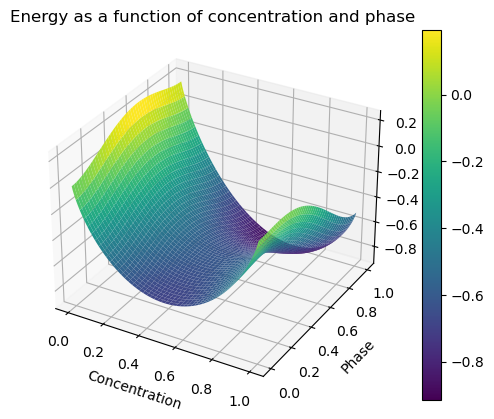

In [5]:
# plot free energy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
size = 0.999
concentration = np.linspace(0.5-size/2, 0.5+size/2, 200)
phase = np.linspace(0.5-size/2, 0.5+size/2, 200)
concentration, phase = np.meshgrid(concentration, phase)

E = fnp(phase, concentration)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(concentration, phase, E, cmap='viridis')

# Add labels and title
ax.set_xlabel('Concentration')
ax.set_ylabel('Phase')
ax.set_zlabel('Energy')
ax.set_title('Energy as a function of concentration and phase')

# Add a color bar for the energy values
fig.colorbar(surf)

# Show the plot
plt.show()

In [6]:
# Create mesh

domain = WorkPlane().Rectangle(1,1).Face()
geo = OCCGeometry(domain, dim=2)
mesh = Mesh(geo.GenerateMesh(maxh=0.005))
Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [7]:
# Create function spaces and solution functions
order=1
fes = H1(mesh, order=order) * H1(mesh, order=order)
(c,phi), (cT, phiT) = fes.TnT()

gf = GridFunction(fes)
gfold = GridFunction(fes)

gfc, gfphi = gf.components
gfcold, gfphiold = gfold.components

In [8]:
# Write down variational forumulation

dt = 1e-3

nphi = gfphiold if explicit else phi
nc = gfcold if explicit else c

if anisotropy:
    theta = theta = IfPos(InnerProduct(grad(nphi),grad(nphi)),acos(grad(nphi)[1]/sqrt(InnerProduct(grad(nphi),grad(nphi)))),0)
    eps = epsbar*(1+delta*cos(j*(theta-theta0)))
    M_1 = M1bar*(1+delta*cos(j*(theta-theta0)))

print(M_1, eps, dt)
a = BilinearForm(fes)
a += (phi-gfphiold) * phiT * dx
a += dt * M_1 * (f(nphi,nc).Diff(nphi) * phiT + eps**2 * grad(phi) * grad(phiT)) * dx
a += (c-gfcold) * cT * dx
# a += dt * nc * (1-nc) * (fB(nphi).Diff(nphi) - fA(nphi).Diff(nphi)) * grad(phi) * grad(cT) * dx
a += dt * nc * (1-nc) * f(gfphiold, gfcold).Diff(gfcold) * (grad(phi) * grad(cT)) * dx
a += dt * grad(c) * grad(cT) * dx

gfold.vec[:] = gf.vec
res = gf.vec.CreateVector()
a.Apply(gf.vec, res)
print(res.Norm())
# a.Assemble()
# print(a.mat.AsVector().Norm())

40 0.025 0.001
0.0


In [9]:
# Create initial random fields phi and c
import random
random.seed(1) # for reproducable results
gfphi.vec = 0
for i in range(mesh.nv):
    gfc.vec[i] = 0.5 + (0.02 * random.random() - 0.01)
    # gfphi.vec[i] = 0.5 + (0.02 * random.random() - 0.01)

Draw(gfc, mesh, "gfc")
Draw(gfphi, mesh, "gfphi")

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [10]:
# Time loop
sphi = Draw(gfphi, mesh, "phi", settings={"_override_data" : { "show_wireframe" : False}},
            # autoscale=False, min=0, max=1)
)
sc = Draw(gfc, mesh, "c", settings={"_override_data" : { "show_wireframe" : False}})

with TaskManager():
    if explicit:
        a.Assemble()
        print("a = ", a.mat.AsVector().Norm())
        ainv = a.mat.Inverse(freedofs=fes.FreeDofs())
        res = gf.vec.CreateVector()

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'_override_data': {'show_wir…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'_override_data': {'show_wir…

a =  0.8060675030794735


In [11]:
# run n steps:
# execute this cell multiple times to proceed in time
nsteps = 0

with TaskManager():
    i = 0
    while i < nsteps:
        i += 1
        gfold.vec.data = gf.vec
        if explicit:
            a.Apply(gf.vec, res)
            # print("res = ", res.Norm())
            gf.vec.data -= ainv * res
        else:
            s = nonlinearsolvers.NewtonSolver(a, gf, inverse="pardiso")
            s.Solve(printing=False)
        # For faster execution, draw for example only every 10th step
        if i % 1 == 0:
            sphi.Redraw()
            sc.Redraw()
        # print("energy = ", Integrate(f(gfphi ,gfc, T), mesh))
        # print("t = ", i*dt, "                                  ", end="\r")